In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

from scipy.stats import qmc

# burgers equation:
# u_t + u*u_x - (0.01/pi)*u_xx = 0
# x in [-1, 1], t in [0, 1]
# u(0, x) = -sin(pi*x)
# u(t, -1) = u(t, 1) = 0


class PINN(nn.Module):
    def __init__(
        self, input_size=2, hidden_size=20, num_hidden_layers=8, output_size=1
    ):
        super(PINN, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.Tanh()]
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, t, x):
        inputs = torch.cat([t, x], dim=1)
        return self.model(inputs)


model = PINN().double()


N_u = 100
N_f = 10000

x_u = torch.rand(N_u, 1).double() * 2 - 1
t_u = torch.zeros(N_u, 1).double()
u_u = -torch.sin(np.pi * x_u)

x_b = torch.ones((N_u // 2, 1))
x_b = torch.cat([x_b, -x_b]).double()
t_b = torch.zeros(N_u, 1).double()
u_b = torch.zeros(N_u, 1).double()

x_u = torch.cat([x_u, x_b]).double()
t_u = torch.cat([t_u, t_b]).double()
u_u = torch.cat([u_u, u_b]).double()

x_u.requires_grad_(True)

u_u.requires_grad_(True)

t_bounts = [0, 1]
x_bounds = [-1, 1]
sampler = qmc.LatinHypercube(d=2)
samples = sampler.random(n=N_f)
t_f = samples[:, 0].reshape(-1, 1) * (t_bounts[1] - t_bounts[0]) + t_bounts[0]
x_f = samples[:, 1].reshape(-1, 1) * (x_bounds[1] - x_bounds[0]) + x_bounds[0]

t_f = torch.tensor(t_f, requires_grad=True).double()
x_f = torch.tensor(x_f, requires_grad=True).double()

# t_f.requires_grad_(True)
# x_f.requires_grad_(True)
t_u.requires_grad_(True)
x_u.requires_grad_(True)


def residual(model, t, x, nu=0.01 / np.pi):
    #     t.requires_grad_(True)
    #     x.requires_grad_(True)
    u = model(t, x)
    u_t = torch.autograd.grad(
        u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True
    )[0]
    u_x = torch.autograd.grad(
        u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True
    )[0]
    u_xx = torch.autograd.grad(
        u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0]
    f = u_t + u * u_x - nu * u_xx
    return f


def loss_function(model, t_u, x_u, u_u, t_f, x_f):
    u_pred = model(t_u, x_u)
    mse_u = torch.mean((u_pred - u_u) ** 2)
    f_pred = residual(model, t_f, x_f)
    mse_f = torch.mean(f_pred**2)
    return mse_u + mse_f


optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=1e0,
    line_search_fn="strong_wolfe",
    max_iter=300,
    max_eval=None,
    tolerance_grad=1e-8,
    tolerance_change=1e-10,
)


def closure():
    optimizer.zero_grad()
    loss = loss_function(model, t_u, x_u, u_u, t_f, x_f)
    loss.backward(retain_graph=True)
    return loss

In [40]:
for epoch in range(10):
    optimizer.step(closure)
    optimizer.zero_grad()
    loss = loss_function(model, t_u, x_u, u_u, t_f, x_f)
    print(f"Epoch {epoch}, Loss {loss.item()}")

Epoch 0, Loss 0.0684857965723111
Epoch 1, Loss 0.034182732951307915
Epoch 2, Loss 0.013952503319535438
Epoch 3, Loss 0.007291517324894822
Epoch 4, Loss 0.005314877860853244
Epoch 5, Loss 0.0032281825125922555
Epoch 6, Loss 0.0022689926364751374
Epoch 7, Loss 0.0015811057135310471
Epoch 8, Loss 0.001126029899260208
Epoch 9, Loss 0.000902868420827681


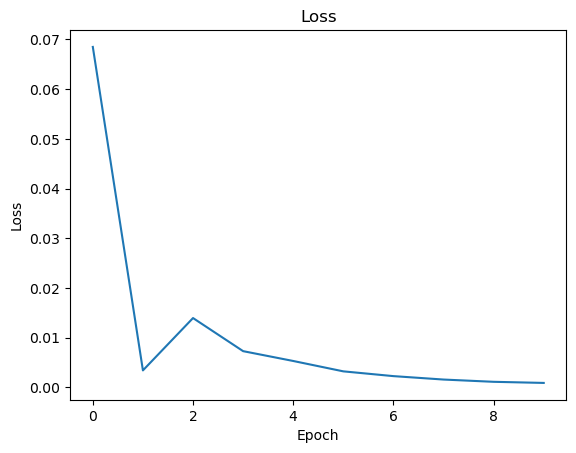

In [44]:
loss = [
    0.06848,
    0.00342,
    0.01395,
    0.007291,
    0.005315,
    0.003228,
    0.002269,
    0.001581,
    0.001126,
    0.000902,
]
plt.figure()
plt.title("Loss")
plt.plot(list(range(10)), loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

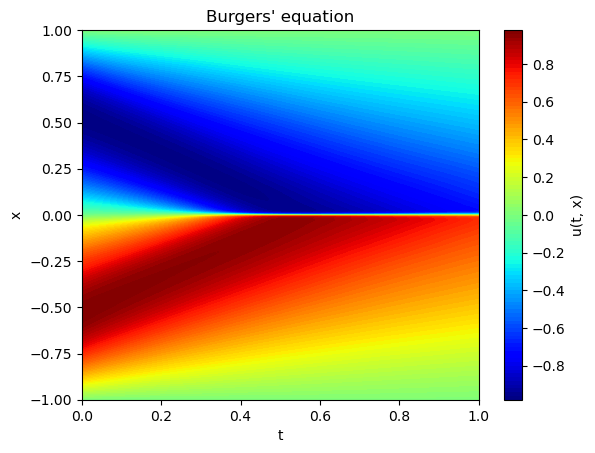

In [41]:
t_vals = torch.linspace(0, 1, 100).reshape(-1, 1).double()
x_vals = torch.linspace(-1, 1, 256).reshape(-1, 1).double()
t_grid, x_grid = torch.meshgrid(t_vals.flatten(), x_vals.flatten())
t_grid = t_grid.contiguous().reshape(-1, 1)
x_grid = x_grid.contiguous().reshape(-1, 1)

u_pred = model(t_grid, x_grid).detach().numpy()
u_pred = u_pred.reshape(100, 256)

import matplotlib.pyplot as plt

plt.figure()
plt.contourf(
    t_vals.flatten().numpy(), x_vals.flatten().numpy(), u_pred.T, 100, cmap="jet"
)
plt.colorbar(label="u(t, x)")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Burgers' equation")
plt.show()

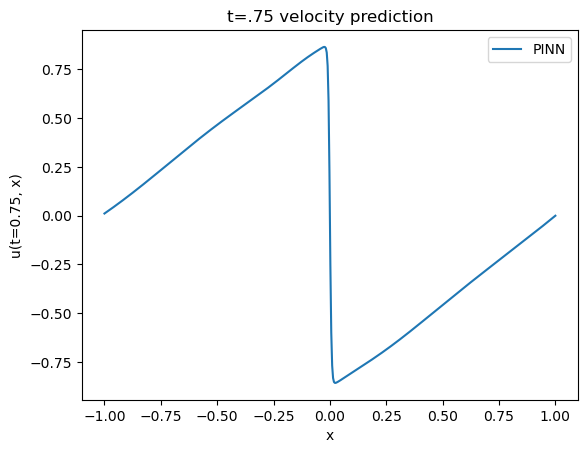

In [43]:
# import mpmath as mp
t_fixed = 0.75
x_fine = torch.linspace(-1, 1, 500, requires_grad=True).reshape(-1, 1).double()
t_fixed_tensor = torch.full_like(x_fine, t_fixed, requires_grad=True)
u_pred = model(t_fixed_tensor, x_fine).detach().numpy()

plt.figure()
plt.title("t=.75 velocity prediction")
plt.plot(x_fine.detach().numpy(), u_pred, label="PINN")
plt.xlabel("x")
plt.ylabel("u(t=0.75, x)")
plt.legend()
plt.show()